## Introduction

## Imports

In [2]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import random
import hashlib



#Increases the resolution of the graphs rendered below by changing image format into vector
%config InlineBackend.figure_formats = ['svg']

In [3]:
#Importing the dataset
dataPath = "raw_data"
df = pd.read_csv(dataPath + "/data_salaries.csv")
#Displaying the first 10 instances of the dataset
df[0:10]

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   
5       2023               SE              FT         Applied Scientist   
6       2023               SE              FT         Applied Scientist   
7       2023               SE              FT            Data Scientist   
8       2023               SE              FT            Data Scientist   
9       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   
5  222200             USD         222200                 US             0   
6  136000             USD         136000                 US             0   
7  219000             USD         219000                 CA             0   
8  141000             USD         141000                 CA             0   
9  147100             USD         147100                 US             0   

  company_location company_size  
0               ES            L  
1               US            S  
2               US            S  
3               CA            M  
4               CA            M  
5               US            L  
6               US            L  
7               CA            M  
8               CA            M  
9               US            M

In [4]:
#Find the number of rows and columns in the dataset
print(df.shape)
#Find the different data types in the dataset
df.dtypes

(3755, 11)


work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

We can see that the distribution of the type of variables in this dataset is roughly 50% categorical and 50% continous, this indicates that we will have to spend roughly equivalent amount of time to look at those variables.

In [5]:
# All ten rows of the dataset all display 2023 for work year
# I want to see if there are other unique entries in this column
df['work_year'].unique()

array([2023, 2022, 2020, 2021], dtype=int64)

In [6]:
# Summary statistics of the data
# For things like outliers or any weird stuff
print("Summary Statistics of Numerical Variables\n", 
      df.select_dtypes(include = "number").describe(),
     "\n")

print("Summary Statistics of Categorical Variables\n",
      df.select_dtypes(include = "object").describe(),
     "\n")

Summary Statistics of Numerical Variables
          work_year        salary  salary_in_usd  remote_ratio
count  3755.000000  3.755000e+03    3755.000000   3755.000000
mean   2022.373635  1.906956e+05  137570.389880     46.271638
std       0.691448  6.716765e+05   63055.625278     48.589050
min    2020.000000  6.000000e+03    5132.000000      0.000000
25%    2022.000000  1.000000e+05   95000.000000      0.000000
50%    2022.000000  1.380000e+05  135000.000000      0.000000
75%    2023.000000  1.800000e+05  175000.000000    100.000000
max    2023.000000  3.040000e+07  450000.000000    100.000000 

Summary Statistics of Categorical Variables
        experience_level employment_type      job_title salary_currency  \
count              3755            3755           3755            3755   
unique                4               4             93              20   
top                  SE              FT  Data Engineer             USD   
freq               2516            3718           1040  

Looking at the above summary statistics we can see that remote ratios may be right skewed as the mean and median do not much. Additionally, for the salary column outliers may be present as the max value for the salary column is two magnitudes higher than the other entries measured in the column. From the categorical variables we can see that there are a lot of unique entries for job title, employee residence, and company location; this suggests that we may have to categorise these variables into smaller categories or encode them for easier data processing.

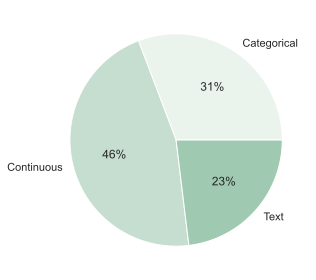

In [7]:
# Graph that illustrates the distribution of data types in this dataset
palette_color = sns.light_palette("seagreen")
FEATURES = [col for col in df.columns if col != 'work_year']
# Separate features into continuous and categorical features correctly
cont_features = [col for col in FEATURES if df[col].nunique() > 10]  # Adjust the threshold as needed
cat_features = [col for col in FEATURES if df[col].nunique() <= 10]  # Adjust the threshold as needed
text_features = ['job_title','company_location','employee_residence']

# Labels for plotting the pie chart
labels = ['Categorical', 'Continuous', 'Text']

# Finds the length of the each array and stores it into value
values= [len(cat_features), len(cont_features), len(text_features)]

# Plotting the pie chart
plt.pie(values, labels=labels, colors=palette_color, autopct='%.0f%%')
plt.show()

In [8]:
# Having a look at whether is there is any missing values for this dataset

print("Summary Statistics of Missing Values \n", 
      df.isnull().sum(axis=0),
     "\n")

Summary Statistics of Missing Values 
 work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64 



No missing values for this dataset! This will make cleaning the data a lot easier.

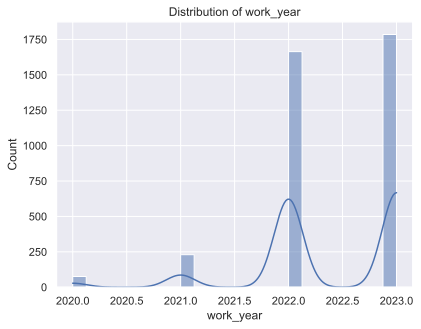

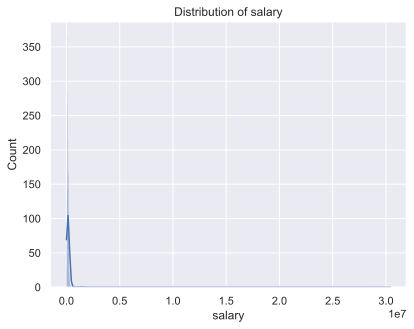

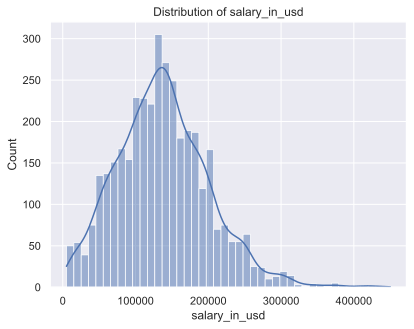

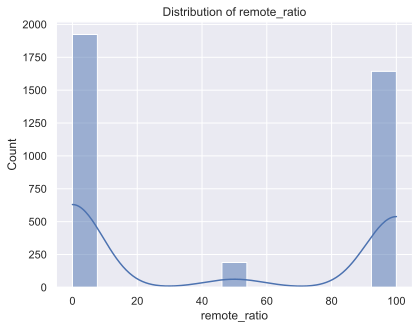

In [9]:
# This looks at the distribution of all numberical data 
for i, v in enumerate(df.select_dtypes(include = "number")):
    sns.histplot(df[v], kde = True)
    plt.title("Distribution of " + v)
    plt.show()

- Looking at work years it indicates to us that majority of the data in this dataset has been collected from 2022 and 2023 while there are some it does include some data from 2020 and 2021. 

- As for salary it seems like the graph looks odd due to the measurement, I will remove the convert it from scientific notation to normal numbers and have a look at the distribution again. 

- For salary in USD it appears like it is fairly normally distributed with a slight right skew - don't think we need to do anything here. 

- Remote ratio seems fairly interesting as it illustrates that most people are either work completely from the office or at home while a small minority is hybrid, I do think the data could be represented better via label encoding. 

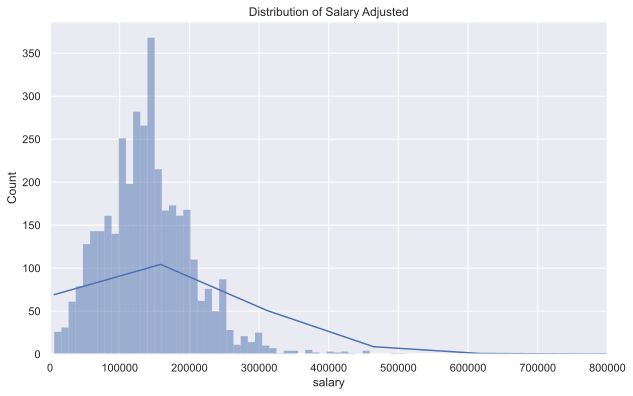

In [10]:
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
plt.figure(figsize=(10, 6))
sns.histplot(df['salary'], kde = True)
plt.title("Distribution of Salary Adjusted")
plt.xlim(-0.02, 800000)
plt.show()

- After adjusting the X axis we can see that the data has a close to normal distribution and is a bit right skewed indicating the presence of outliers within the dataset. 

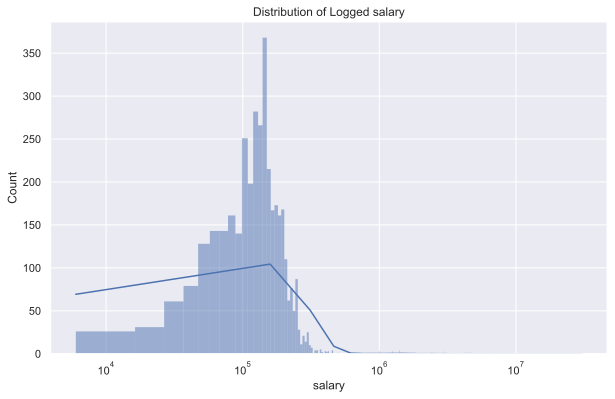

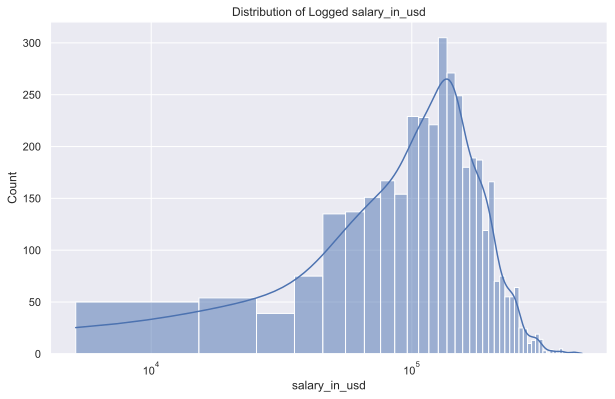

In [11]:
# Both salary in USD and salary are both right skewed 
# Lets try logging the data and see if it becomes more normally distrubted

for i, v in enumerate(["salary", "salary_in_usd",]):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[v], kde = True)
    plt.xscale("log")
    plt.title("Distribution of Logged " + v)
    plt.show()

- We can see that after logging the data the shape of the graph does not improve
- We should just stick to the original graph and instead clean the data later on in data cleaning

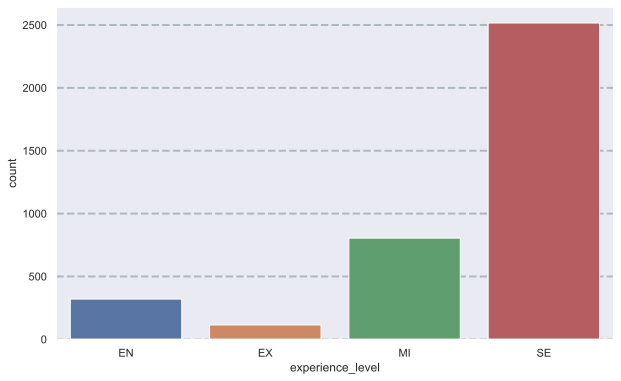

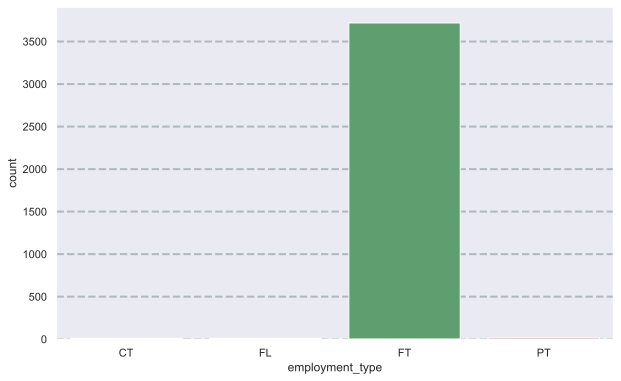

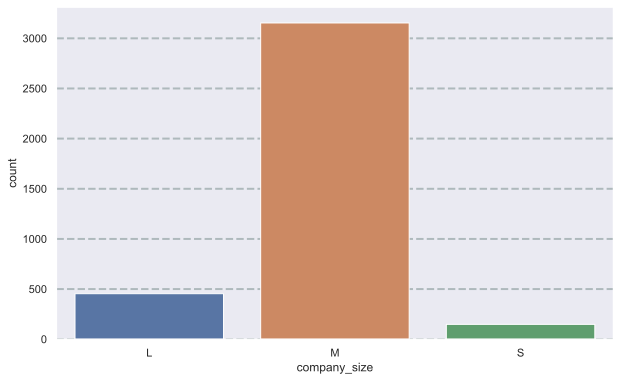

In [12]:
# Now lets proceed to look at the categorical variables


for i, v in enumerate(['experience_level','employment_type', 'company_size']):
    plt.figure(figsize=(10, 6))
    sns.countplot(x = df[v].astype('category'))
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
    plt.show()


There is a number of interesting things we can see from the categorical data above:
- Interestingly enough it seems like the most common experience level in this dataset is SE which typically corresponds to sensior or excutive level of experience.
- In terms of the employment type it appears like everyone falls under FT which typically corresponds to full time employment, will further verify there is no other unique entries.
- Medium sized company appears to be the most frequent

In [13]:
# Check the number of unique variables in the employment type column
print(df['employment_type'].unique())

# Checks the frequency of each variable in the column
df1 = df['employment_type'].value_counts()
print(df1)

['FT' 'CT' 'FL' 'PT']
FT    3718
PT      17
CT      10
FL      10
Name: employment_type, dtype: int64


From this we can see that the dataset doesn't only contain employees that are full there are other employment types as well with full time being the most common by a large margin. 

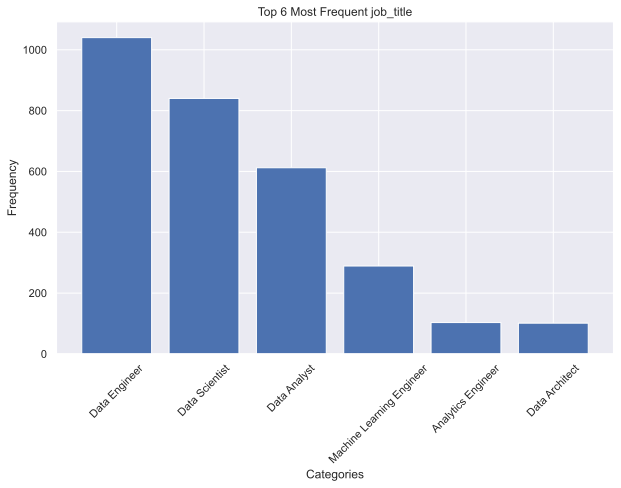

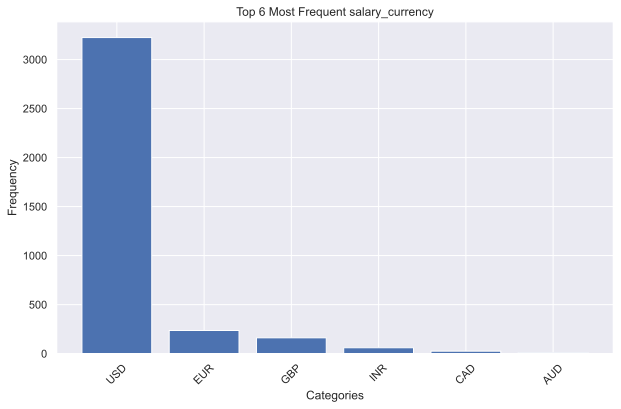

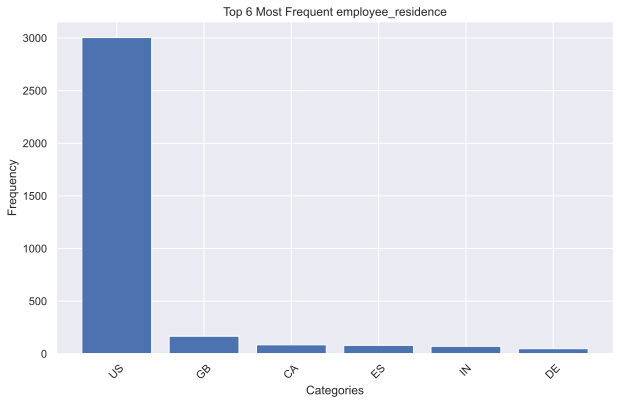

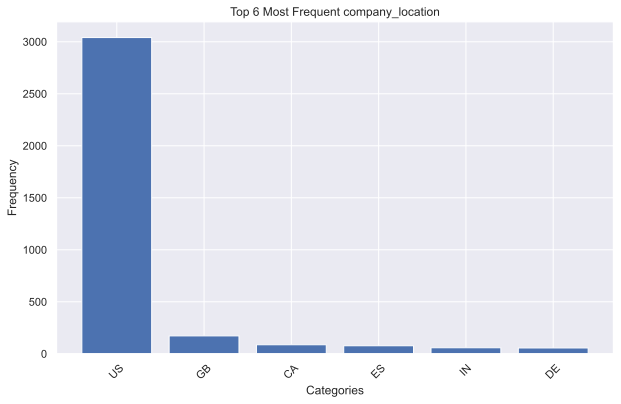

In [14]:

# Define number of top categories to display
top_n = 6

# Define list of columns to visualise
columns_to_visualise = ['job_title','salary_currency', 'employee_residence', 'company_location']

#Loop through each column
for col in columns_to_visualise:
    
    # Get the frequency counts of each category in the current column
    category_counts = df[col].value_counts()
    
    # Select the top N most frequent categories
    top_categories = category_counts.head(top_n)
    # Create a new figure for each column's visualization
    plt.figure(figsize=(10, 6))
    plt.bar(top_categories.index, top_categories.values)
    # Set labels and title for the plot

    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Most Frequent {col}')
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    # Display the plot
    plt.show()

From looking at the frequency graphs we can identify the following:
- The most common position in this dataset is data engineer
- For the categories with a lot of different variables such as company location and employee residence, although there is a large number of unique categories the most frequent is US by a large margin with only a small amount of individuals in other categories.
- Employee residence and company location may have a strong correlation which we can look at later

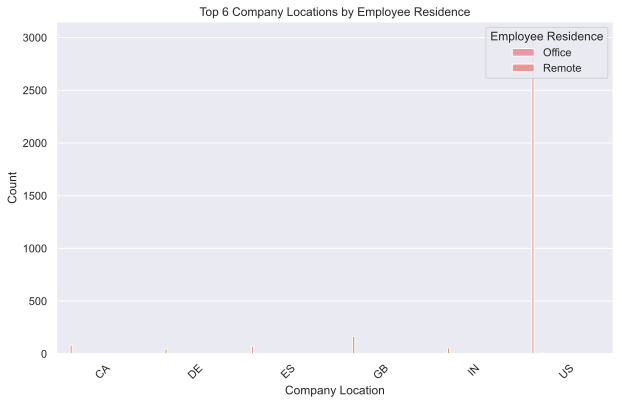

In [15]:
top_n = 6

category_counts = df['company_location'].value_counts()

# Select the top N most frequent categories
top_categories = category_counts.head(top_n).index.tolist()

# Filter the DataFrame to include only rows with the top categories in 'company_location'
filtered_df = df[df['company_location'].isin(top_categories)]

# Plot the countplot with the specified hue
plt.figure(figsize=(10, 6))
sns.countplot(x=filtered_df["company_location"].astype('category'), hue=filtered_df["employee_residence"])
plt.xlabel('Company Location')
plt.ylabel('Count')
plt.title(f'Top {top_n} Company Locations by Employee Residence')
plt.legend(title='Employee Residence', loc='upper right', labels=['Office', 'Remote'])
plt.xticks(rotation=45)
plt.show()

## Pre-lim Cateogrical Feature Conversion

In [16]:
# Encoding Spending_Score using label encoding
# Using label encoding as spending score is ordinal data

# Creating a instance of label encoder
le = LabelEncoder()
# Assigning numerical values and storing in another column

df['company_size_lab'] = le.fit_transform(df['company_size'])

#

## Data Cleaning

In [17]:
df.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  company_size_lab  
0               ES            L                 0  
1               US            S                 2  
2               US            S                 2  
3               CA            M                 1  
4               CA            M                 1

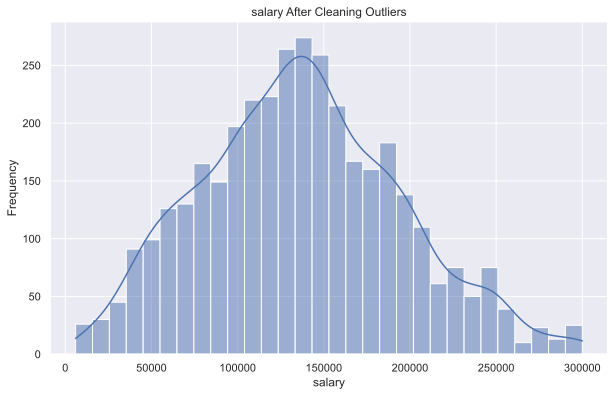

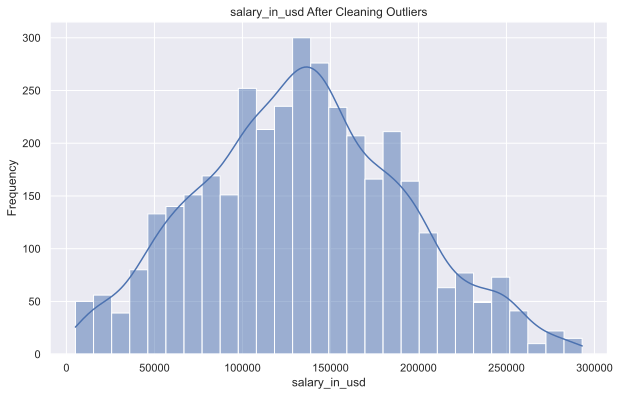

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  company_size_lab  salary_cleaned  \
0               ES            L                 0       80000.000   
1               US            S                 2       30000.000   
2               US            S                 2       25500.000   
3               CA            M                 1      175000.000   
4               CA            M                 1      120000.000   

   salary_in_usd_cleaned  
0              85847.000  
1              30000.000  
2              25500.000  
3             175000.000  
4             120000.000

In [18]:
def clean_outliers_iqr(data, factor=1.5):
    """
    Clean outliers from the data using the Interquartile Range (IQR) method.

    Parameters:
        data (pd.Series or pd.DataFrame): The data to clean.
        factor (float, optional): Multiplier for the IQR. Default is 1.5.

    Returns:
        pd.Series or pd.DataFrame: The data without outliers.
    """
    # Remove negative values before calculating Q1 and Q3
    data_no_negatives = data[data >= 0]

    # Calculate the first quartile (Q1) and third quartile (Q3) of the data without negatives
    Q1 = data_no_negatives.quantile(0.25)
    Q3 = data_no_negatives.quantile(0.75)

    # Calculate the Interquartile Range (IQR) by subtracting Q1 from Q3
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds to identify outliers
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    # Return the data with outliers removed, i.e., data within the lower and upper bounds
    return data[(data >= lower_bound) & (data <= upper_bound)]

# The columns that has outliers
columns_to_clean = ['salary', 'salary_in_usd']

for col in columns_to_clean:
    cleaned_data = clean_outliers_iqr(df[col])  # Corrected the syntax here
    
    # Create new column names for cleaned data
    new_col_name = f"{col}_cleaned"
    
    # Add the cleaned data as a new column to the dataframe
    df[new_col_name] = cleaned_data
    
    plt.figure(figsize=(10, 6))
    sns.histplot(cleaned_data, kde=True)
    plt.title(f"{col} After Cleaning Outliers")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

df.head()

## Finding correlation

In [19]:
df.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location company_size  company_size_lab  salary_cleaned  \
0               ES            L                 0       80000.000   
1               US            S                 2       30000.000   
2               US            S                 2       25500.000   
3               CA            M                 1      175000.000   
4               CA            M                 1      120000.000   

   salary_in_usd_cleaned  
0              85847.000  
1              30000.000  
2              25500.000  
3             175000.000  
4             120000.000

C:\Users\james\AppData\Local\Temp\ipykernel_1964\1117566117.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()
C:\Users\james\AppData\Local\Temp\ipykernel_1964\1117566117.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, mask = np.triu(df.corr()))


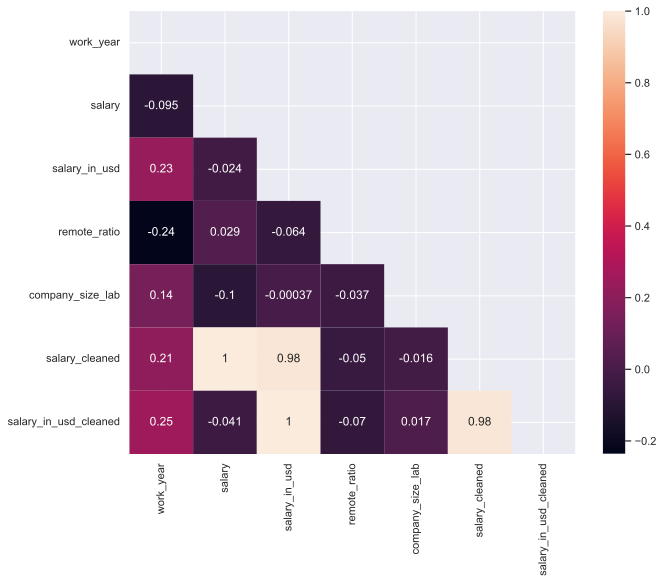

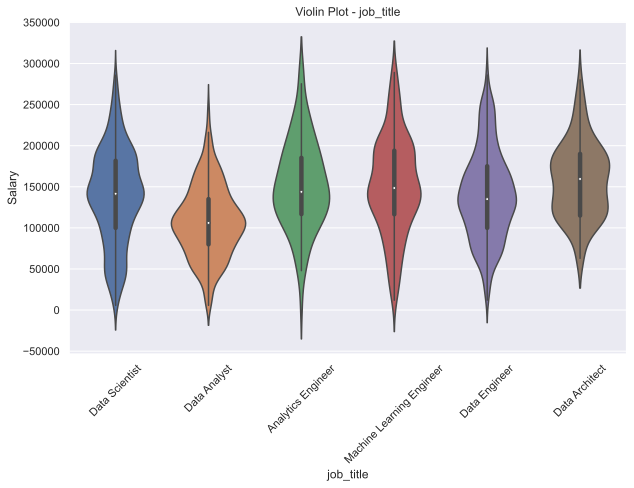

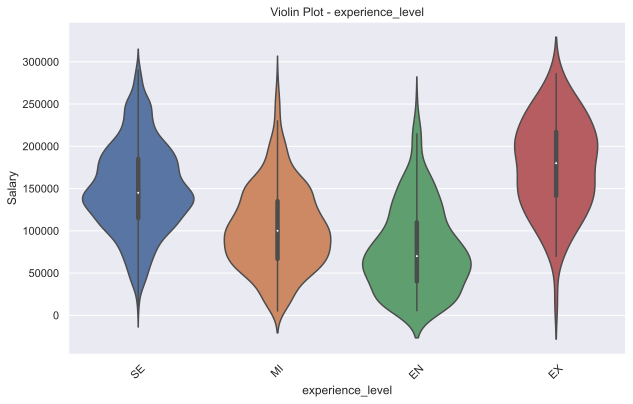

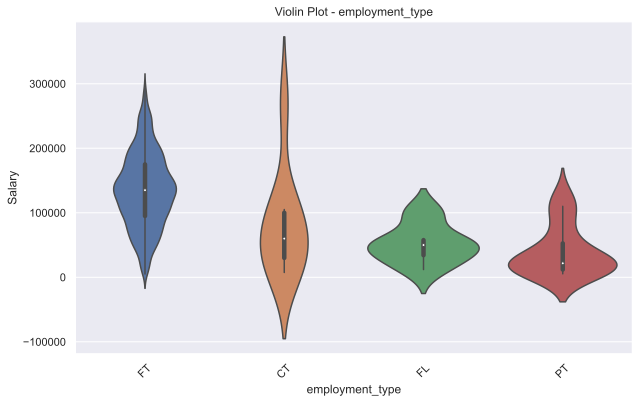

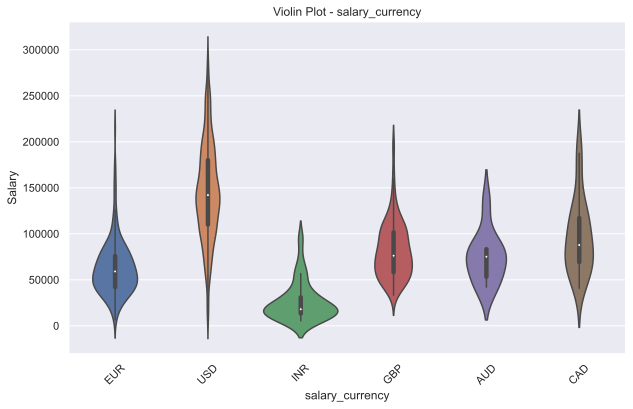

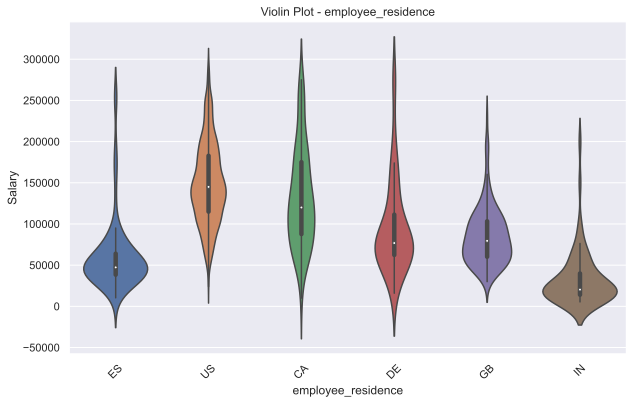

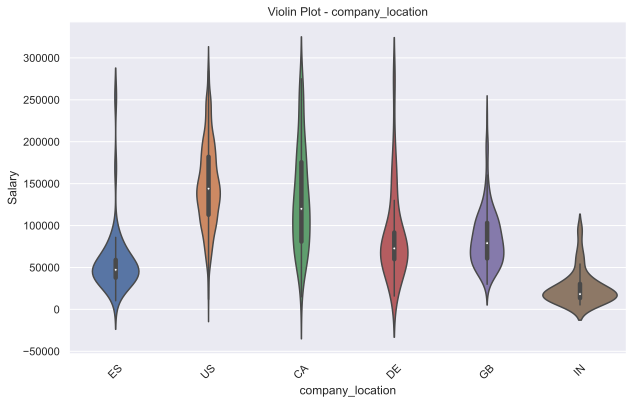

In [20]:
# Heat map to visualise correlation between the variables

correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot = True, mask = np.triu(df.corr()))
plt.show()

# For the categorical variables we can use regular plots to find the correlation
cat_variables = ['job_title','experience_level','employment_type','salary_currency','employee_residence','company_location']
def get_top_categories(column, n=6):
    return column.value_counts().nlargest(n).index

for v in cat_variables:
    top_categories = get_top_categories(df[v])
    filtered_df = df[df[v].isin(top_categories)]

    plt.figure(figsize=(10, 6))
    sns.violinplot(x=v, y='salary_in_usd_cleaned', data=filtered_df)
    plt.title(f'Violin Plot - {v}')
    plt.xlabel(v)
    plt.ylabel('Salary')
    plt.xticks(rotation=45)
    plt.show()

From the violin plots with the categorical columns plotted against salary we can notice the following:

- For the most common job titles it seems like the median for most of them are roughly the same with data analyst being the only one that's a little lower
- In terms of the experience level although I'm not certain what EX stands for but its median is clearly higher than the other experience levels with SE, MI and EN in descending order.
- As for employment types full time employment has the highest median salary which makes sense as it indicates more hours of work compared to the other employment types
- Individuals with the highest median salary tend to have it in USD
- Individuals that have the highest salary tend to live in the US along with their company also being in the US, while India has the largest range of salaries 


In [21]:
catVarsOneHot = ["experience_level", "employment_type",]
dummyVars = pd.concat([pd.get_dummies(df[v], prefix = v) for v in catVarsOneHot], axis = 1)

df = pd.concat([df, dummyVars], axis=1)


In [22]:
# Salary currency, employee residence, company location and job title all have a large number of unique variables
# Therefore I will opt to encode it using hash encoding as it reduces the dimensionality of the dataset

import pandas as pd
import hashlib


def hash_encode(column):
    """
    Hash encode a categorical column using MD5 hash function.

    Parameters:
        column (pd.Series): The categorical column to hash encode.

    Returns:
        pd.Series: The hash encoded values.
    """
    encoded_values = column.apply(lambda x: int(hashlib.md5(x.encode()).hexdigest(), 16) % (10 ** 8))
    return encoded_values

hash_columns = ['salary_currency', 'employee_residence', 'company_location', 'job_title']
# Apply hash encoding to the 'category_column'
for col in hash_columns:
    df[col + '_encoded'] = hash_encode(df[col])


In [23]:
df.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   
3  175000             USD         175000                 CA           100   
4  120000             USD         120000                 CA           100   

  company_location  ... experience_level_MI  experience_level_SE  \
0               ES  ...                   0                    1   
1               US  ...                   1                    0   
2               US  ...                   1                    0   
3               CA  ...                   0                    1   
4               CA  ...                   0                    1   

   employment_type_CT  employment_type_FL  employment_type_FT  \
0                   0                   0                   1   
1                   1                   0                   0   
2                   1                   0                   0   
3                   0                   0                   1   
4                   0                   0                   1   

   employment_type_PT  salary_currency_encoded  employee_residence_encoded  \
0                   0                 49064728                    81406157   
1                   0                 51126126                    25370322   
2                   0                 51126126                    25370322   
3                   0                 51126126                    21365473   
4                   0                 51126126                    21365473   

   company_location_encoded  job_title_encoded  
0                  81406157            2058566  
1                  25370322           10028239  
2                  25370322           10028239  
3                  21365473           72608695  
4                  21365473           72608695  

[5 rows x 26 columns]

In [24]:
# Saving all the relevant and encoded variables into a new dataset for machine learning

varToSave = ["work_year", "salary_cleaned","salary_in_usd_cleaned","company_size_lab", "salary_currency_encoded","employee_residence_encoded","company_location_encoded","remote_ratio","job_title_encoded"]
cleanpath = "cleaned_data"
pd.concat([df[varToSave], dummyVars], axis = 1).to_csv(cleanpath + "/data_salaries_cleaned.csv", index = False)
